In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, ConnectionPatch
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib.colors import ListedColormap

# ML
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from kernels import sqeuclidean_distances

# Atoms
from ase.io import read

# Utilities
import h5py
import json
from tools import load_json
import project_utils as utils

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Analysis setup

In [4]:
# Load SOAP cutoffs
soap_hyperparameters = load_json('../../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

In [5]:
# Load train and test indices
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_test.idxs', dtype=int)

iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_test.idxs', dtype=int)

In [6]:
# Load indices of DEEM 10k set in 330k
idxs_deem_10k = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)

In [15]:
# Load cantons for IZA and Deem
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)
deem_cantons_2 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)
deem_cantons_4 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_4-class.dat', dtype=int)
deem_cantons = deem_cantons_4
n_deem = len(deem_cantons_2)

In [8]:
# Build set of "master" canton labels for the train set
train_cantons = {}

train_cantons[4] = np.concatenate((
    iza_cantons[iza_train_idxs], 
    deem_cantons_4[deem_train_idxs]
))

train_cantons[2] = np.concatenate((
    np.ones(len(iza_train_idxs), dtype=int),
    deem_cantons_2[deem_train_idxs]
))

train_class_weights = {
    n_cantons: utils.balanced_class_weights(train_cantons[n_cantons]) for n_cantons in (2, 4)
}

# Build set of "master" canton labels for the test set
test_cantons = {}

test_cantons[4] = np.concatenate((
    iza_cantons[iza_test_idxs], 
    deem_cantons_4[deem_test_idxs]
))

test_cantons[2] = np.concatenate((
    np.ones(len(iza_test_idxs), dtype=int),
    deem_cantons_2[deem_test_idxs]
))

test_class_weights = {
    n_cantons: utils.balanced_class_weights(test_cantons[n_cantons]) for n_cantons in (2, 4)
}

In [9]:
class_names = {
    2: ['IZA', 'DEEM'],
    4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']

}

ticklabels = {
    2: ['IZA', 'DEEM'],
    4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']
}

In [10]:
# Linear model setup
n_species = 2
group_names = {
    'power': ['OO', 'OSi', 'SiSi', 'OO+OSi', 'OO+SiSi', 'OSi+SiSi', 'OO+OSi+SiSi'], 
    'radial': ['O', 'Si', 'O+Si']
}

In [11]:
deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

## Plotting

In [34]:
mixing = ''

===== 3.5 | 4-Class | Power | OO =====


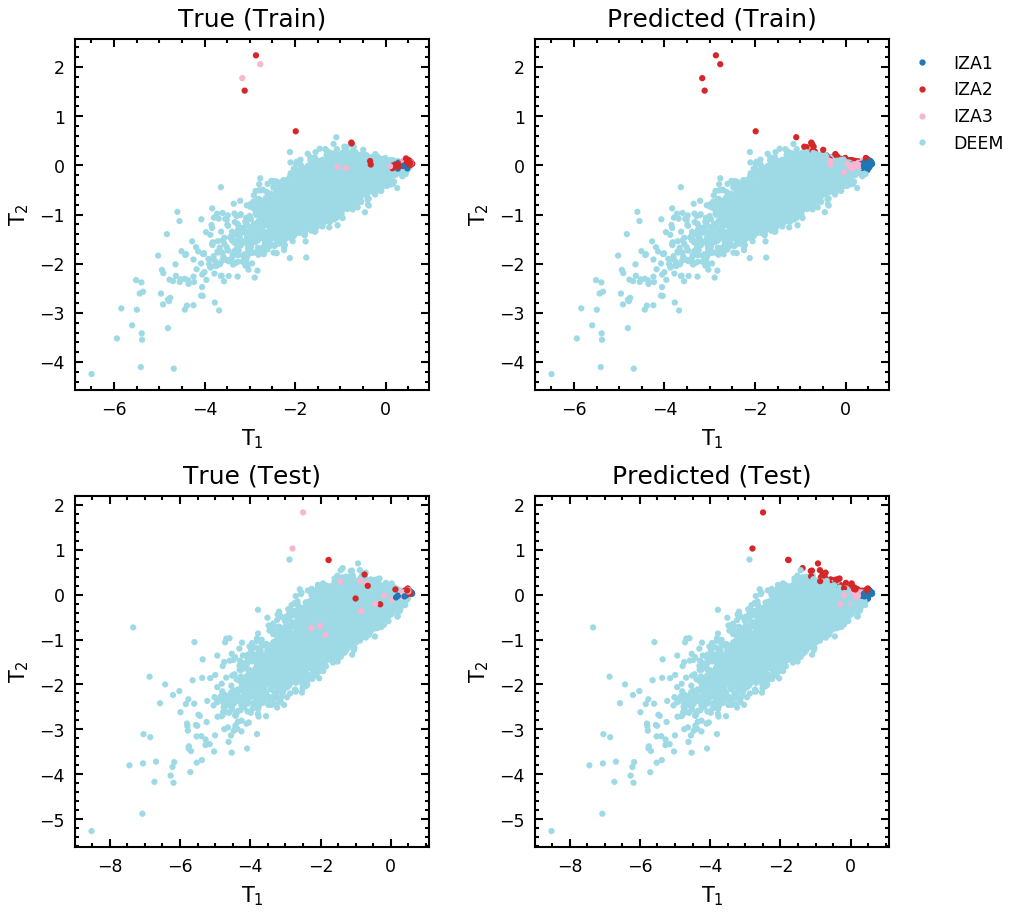

===== 3.5 | 4-Class | Power | OSi =====


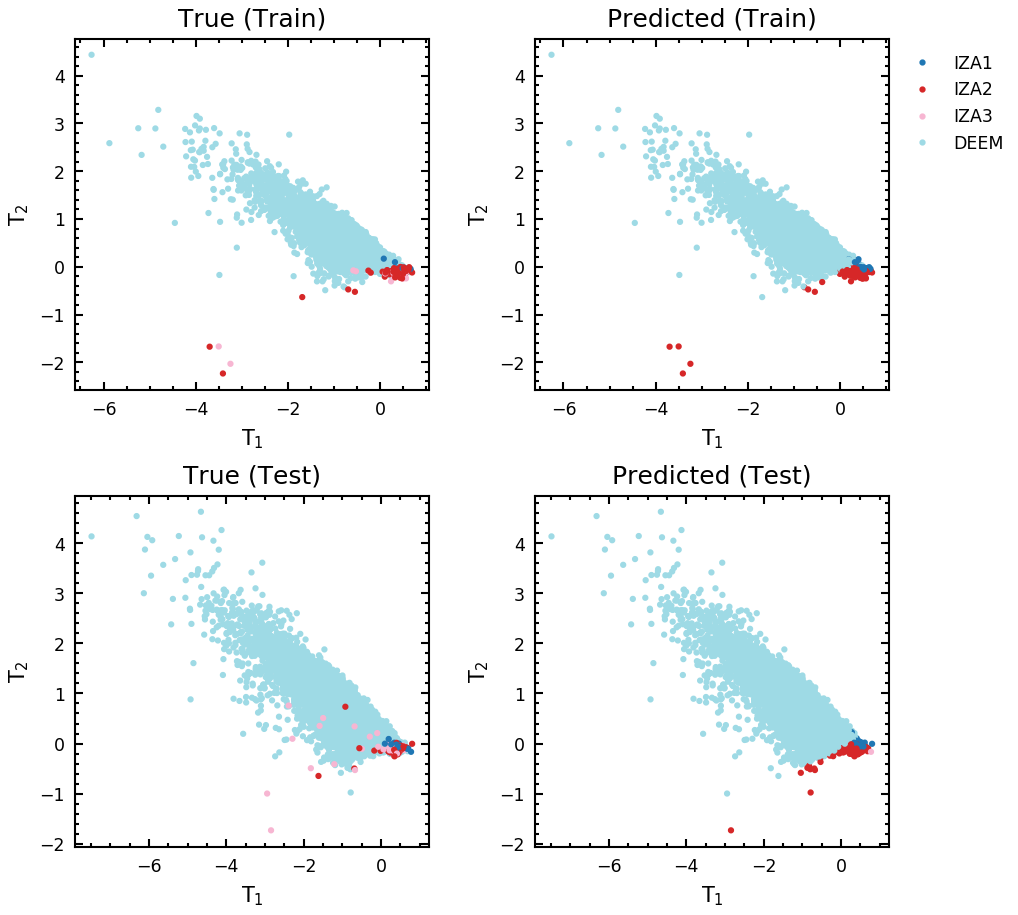

===== 3.5 | 4-Class | Power | SiSi =====


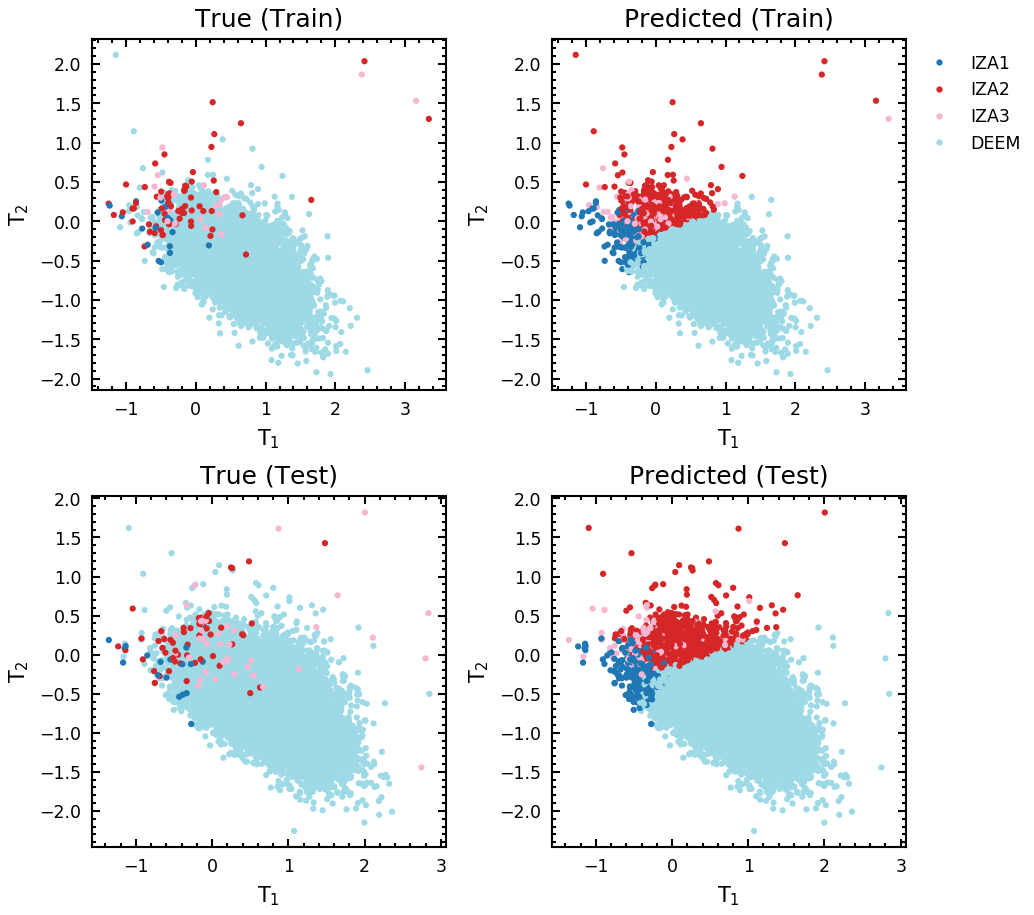

===== 3.5 | 4-Class | Power | OO+OSi =====


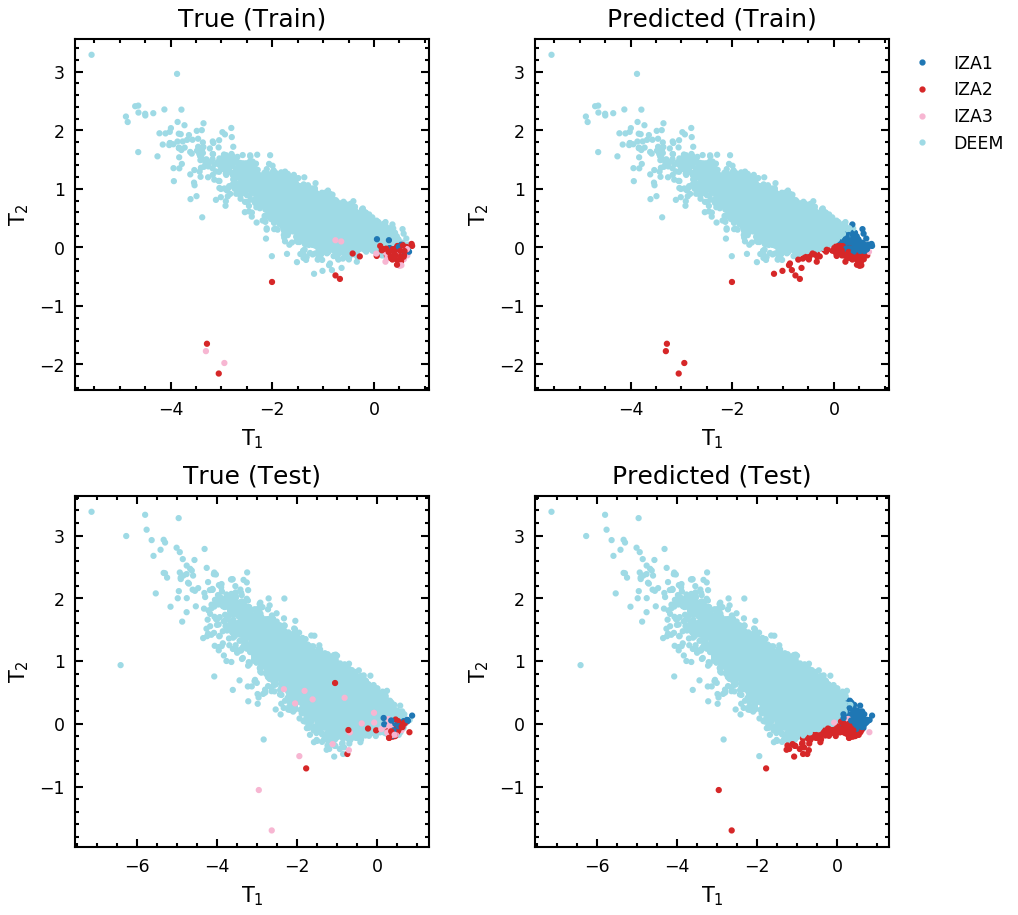

===== 3.5 | 4-Class | Power | OO+SiSi =====


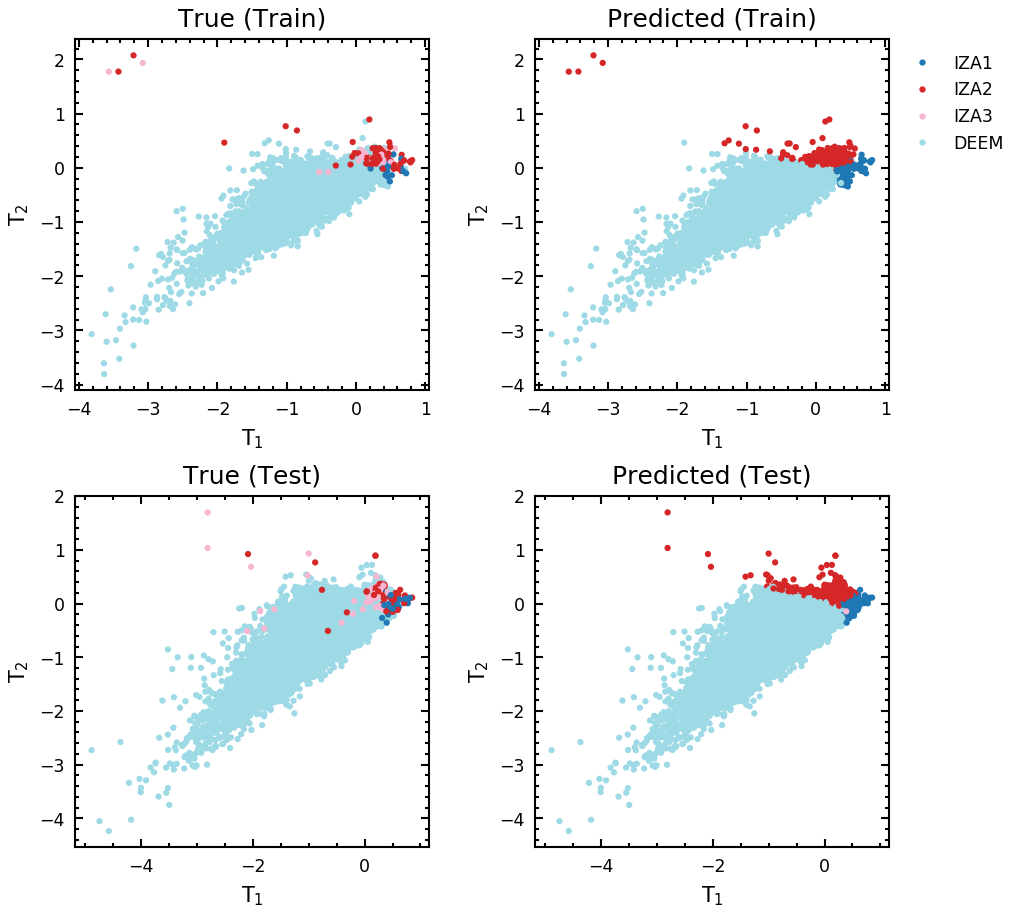

===== 3.5 | 4-Class | Power | OSi+SiSi =====


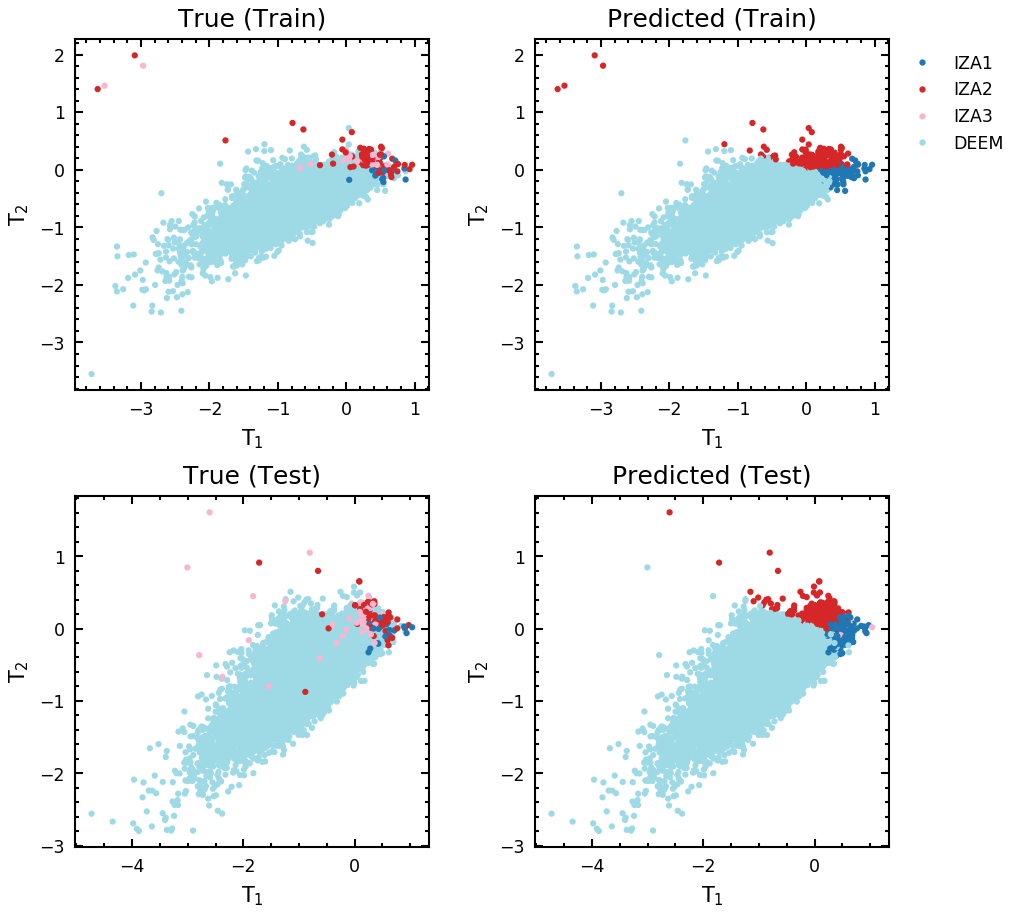

===== 3.5 | 4-Class | Power | OO+OSi+SiSi =====


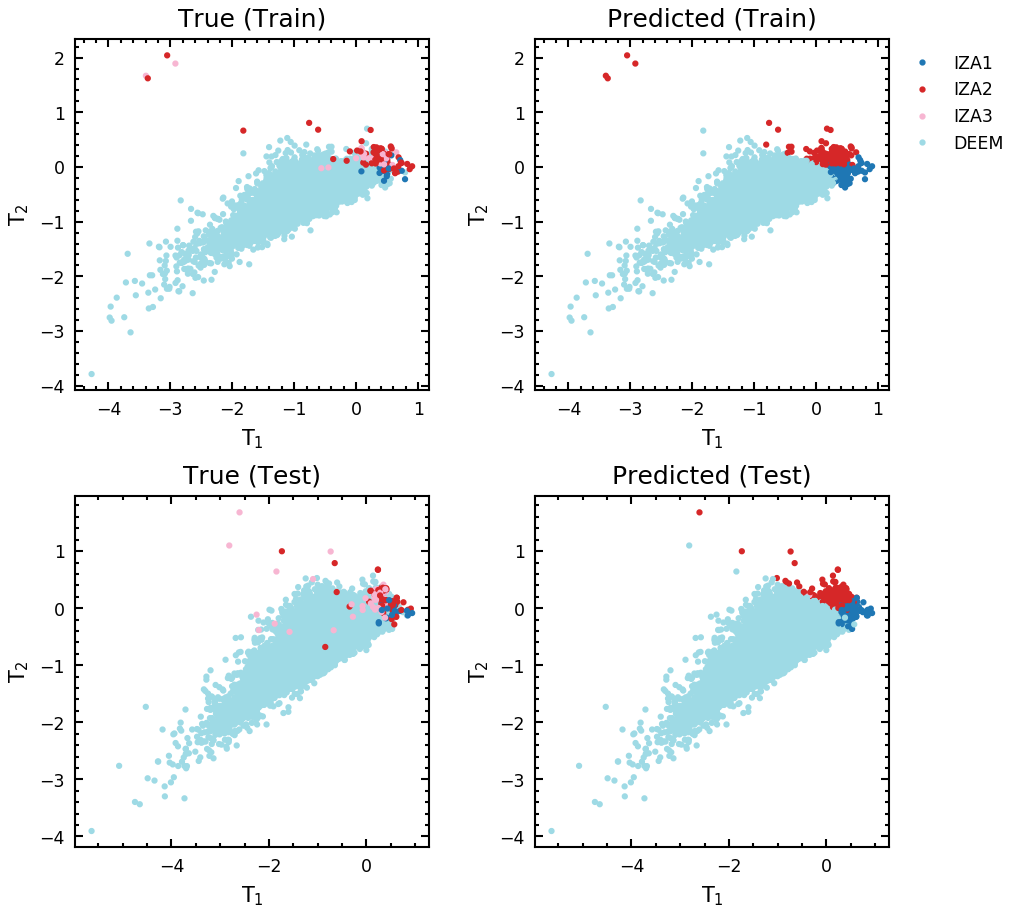

===== 3.5 | 4-Class | Radial | O =====


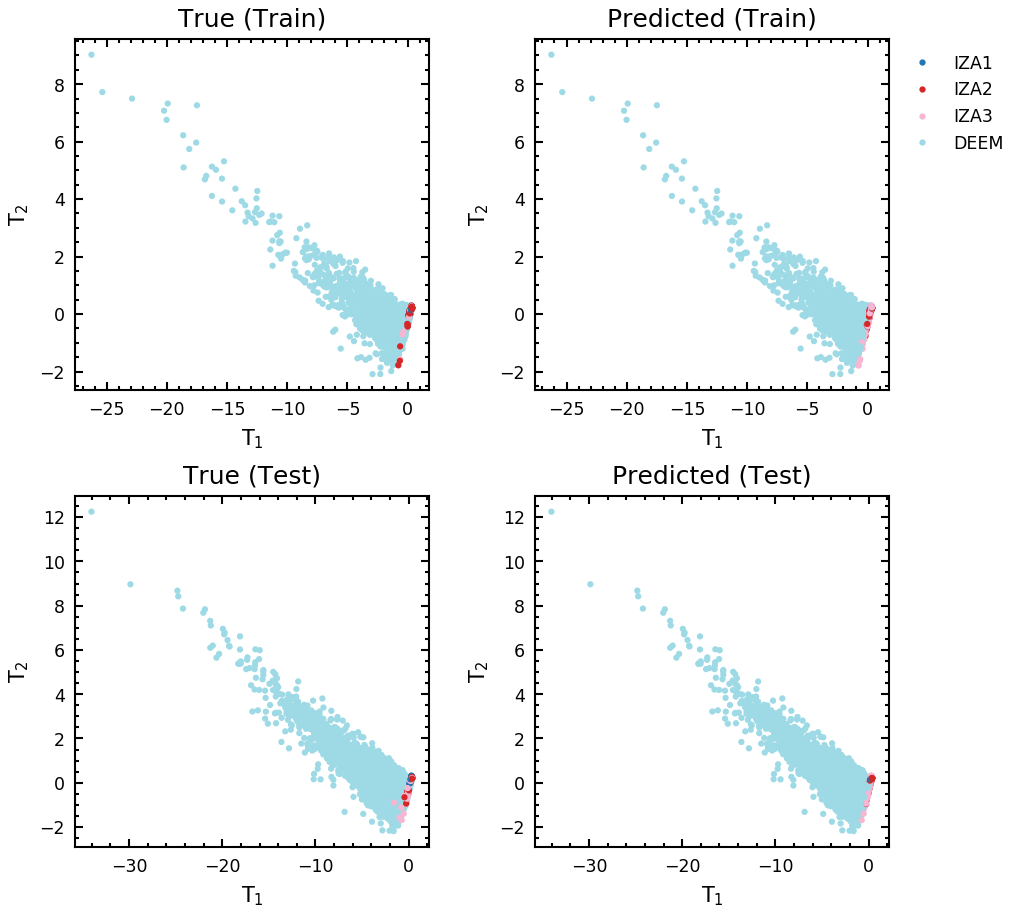

===== 3.5 | 4-Class | Radial | Si =====


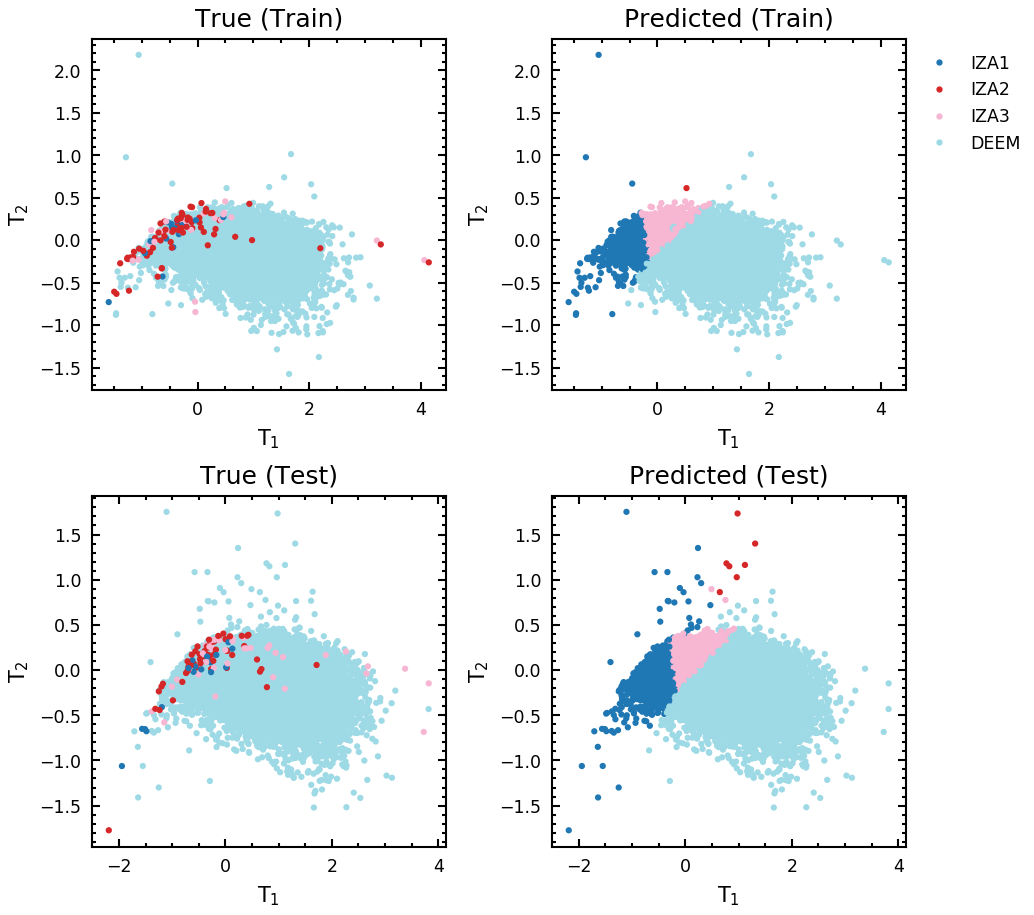

===== 3.5 | 4-Class | Radial | O+Si =====


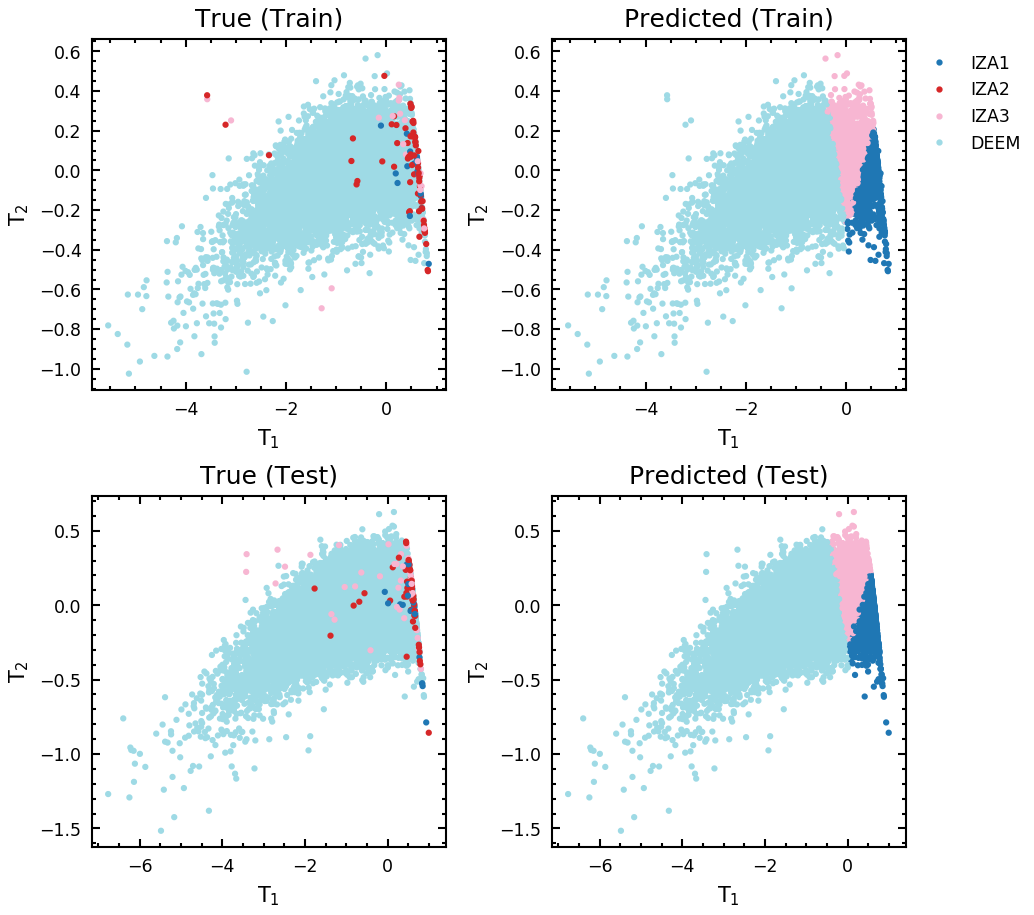

===== 6.0 | 4-Class | Power | OO =====


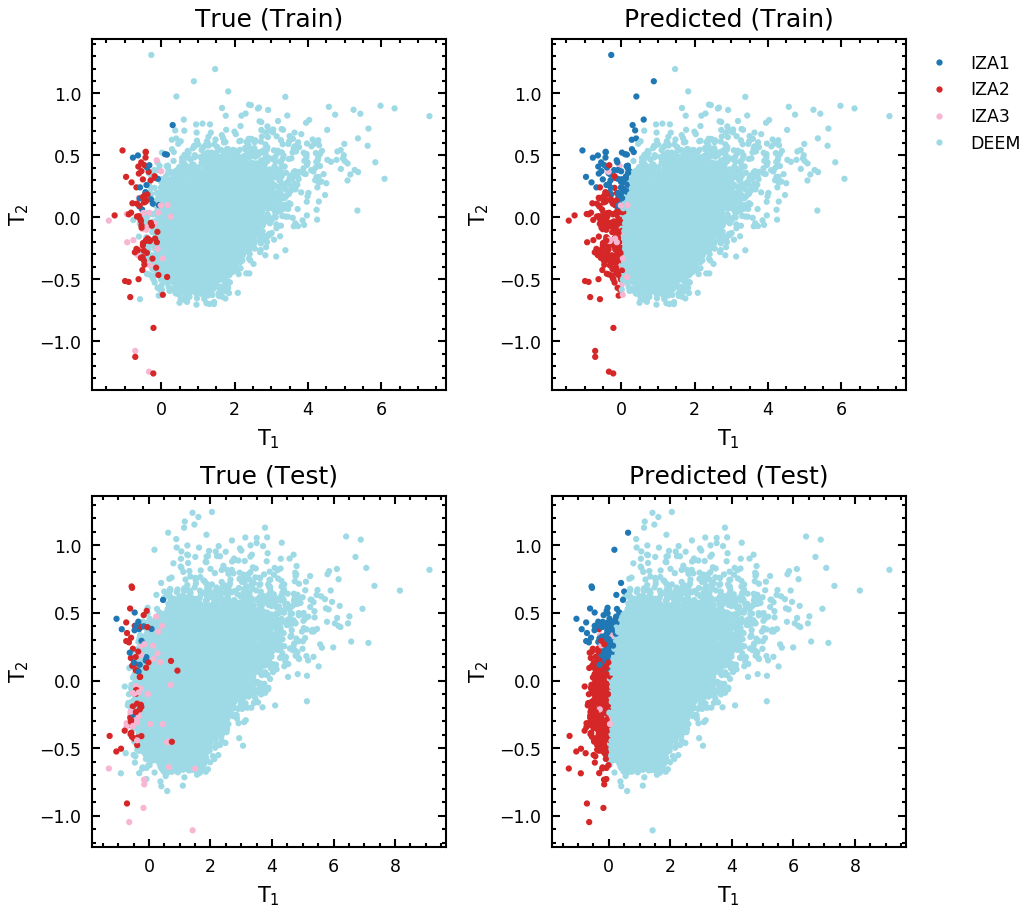

===== 6.0 | 4-Class | Power | OSi =====


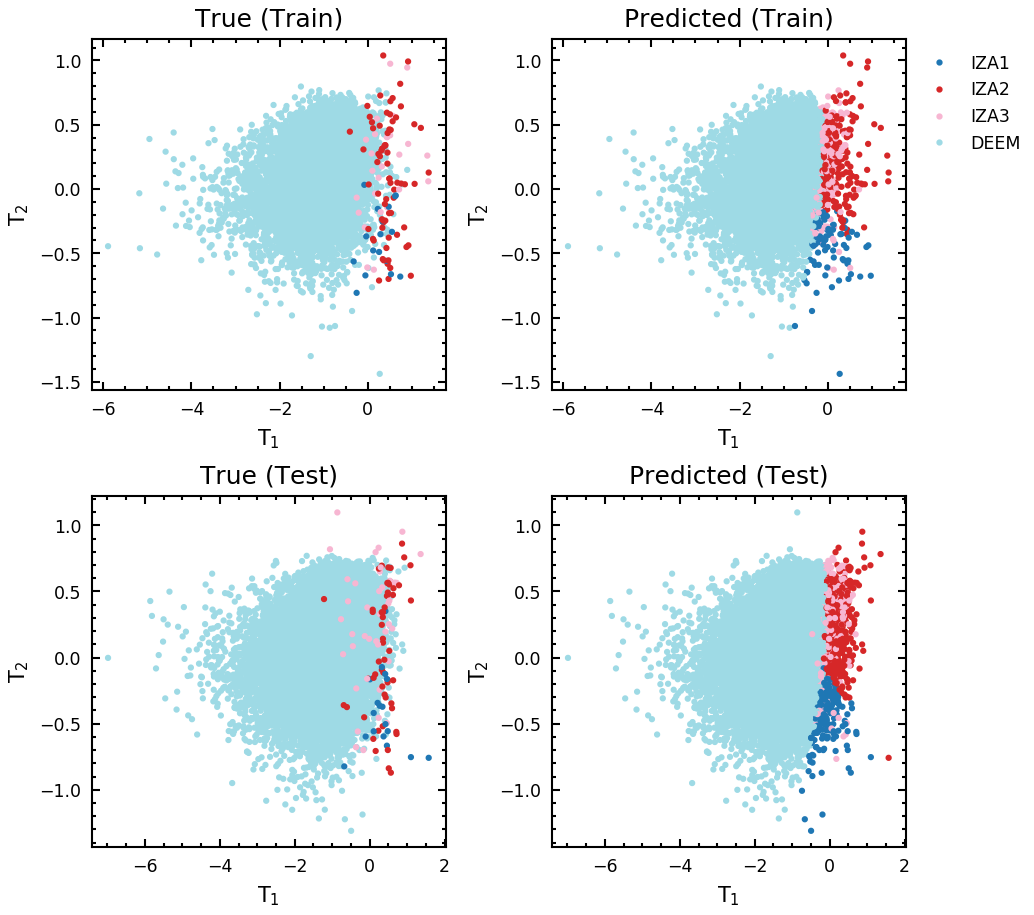

===== 6.0 | 4-Class | Power | SiSi =====


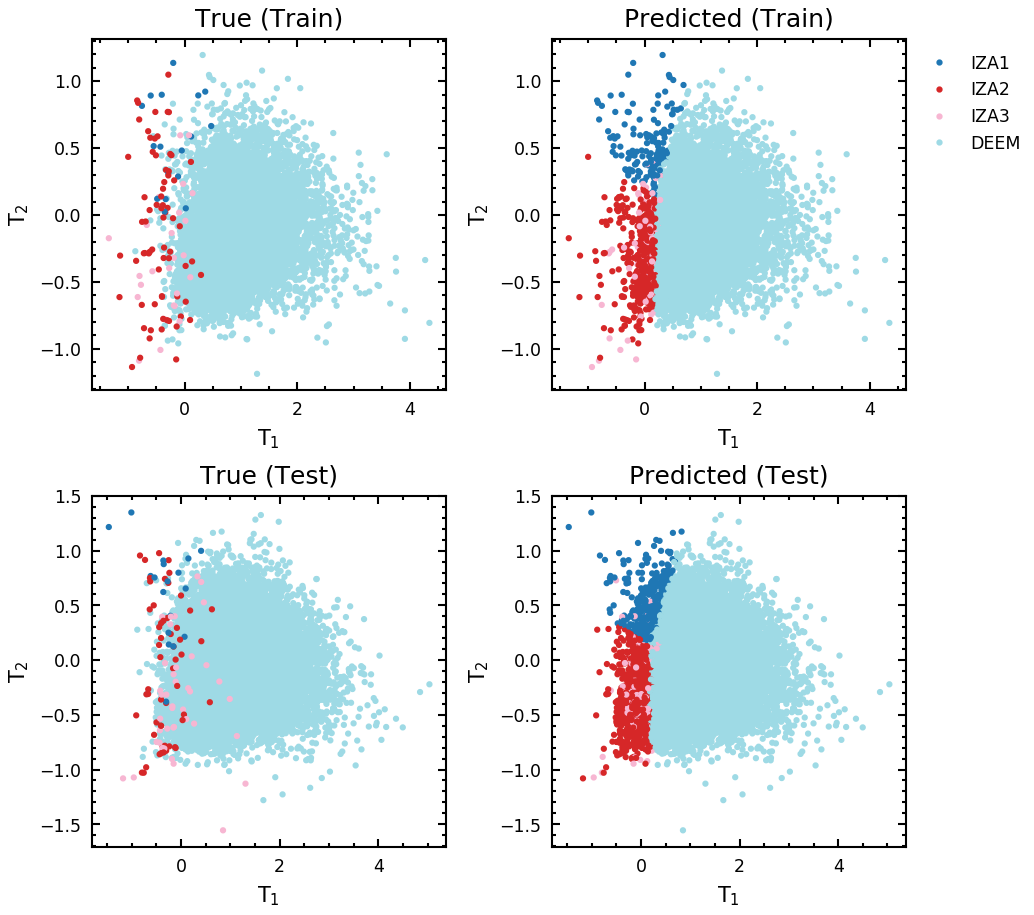

===== 6.0 | 4-Class | Power | OO+OSi =====


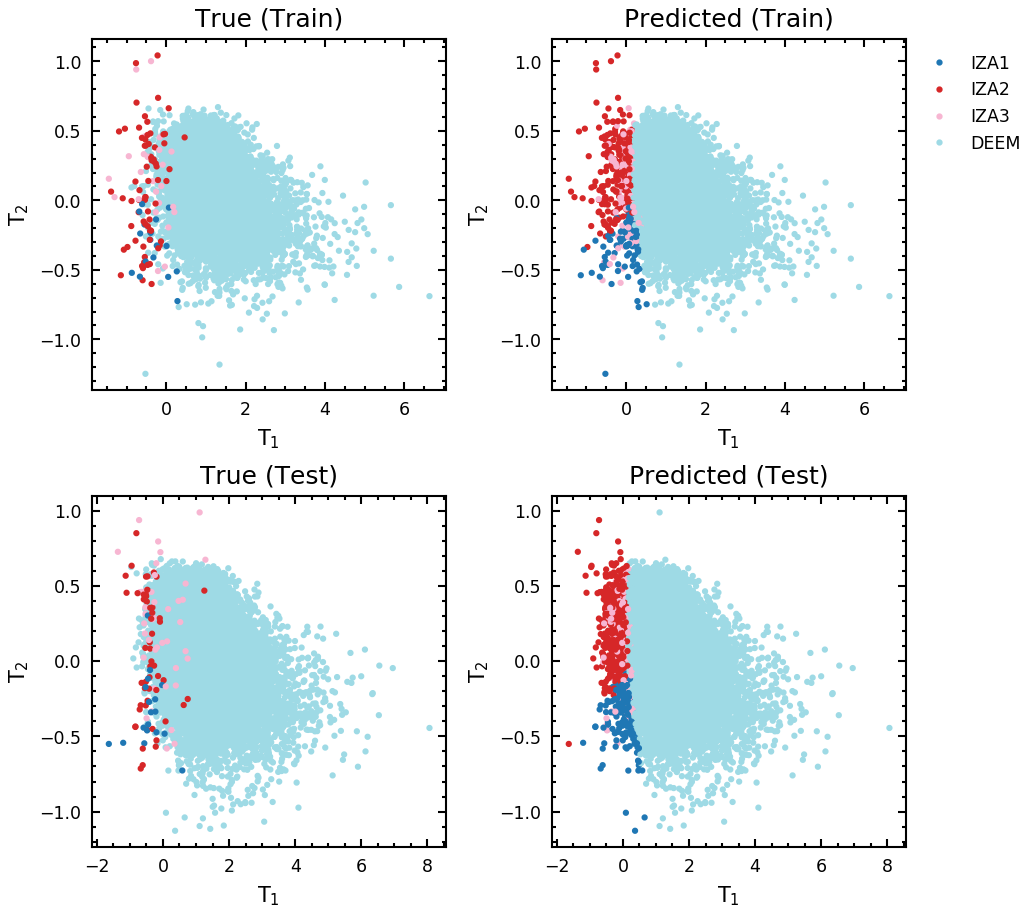

===== 6.0 | 4-Class | Power | OO+SiSi =====


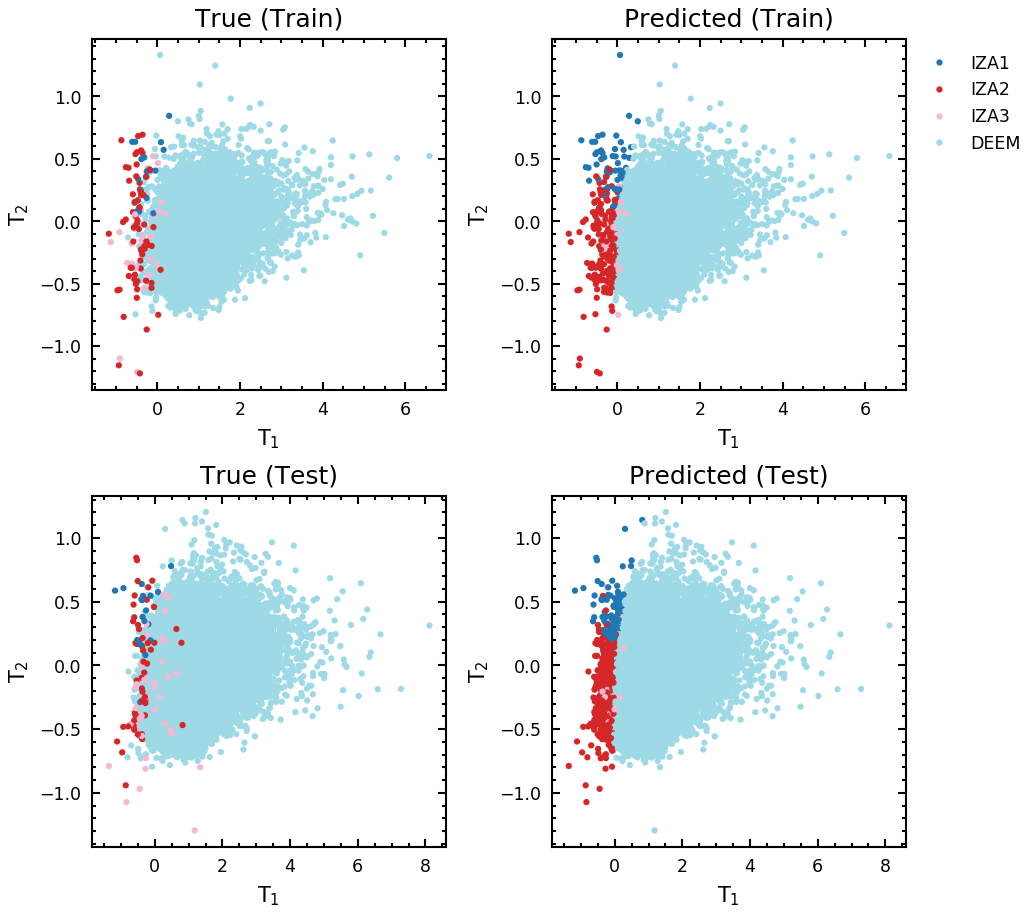

===== 6.0 | 4-Class | Power | OSi+SiSi =====


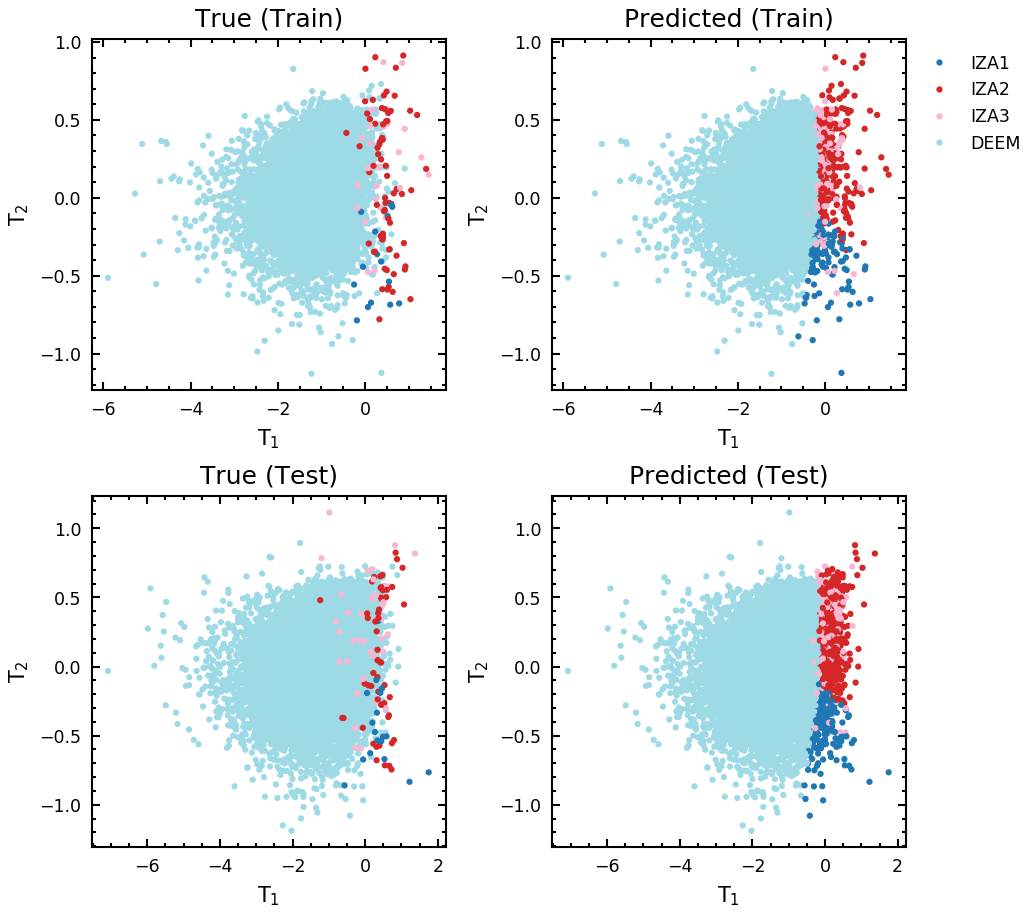

===== 6.0 | 4-Class | Power | OO+OSi+SiSi =====


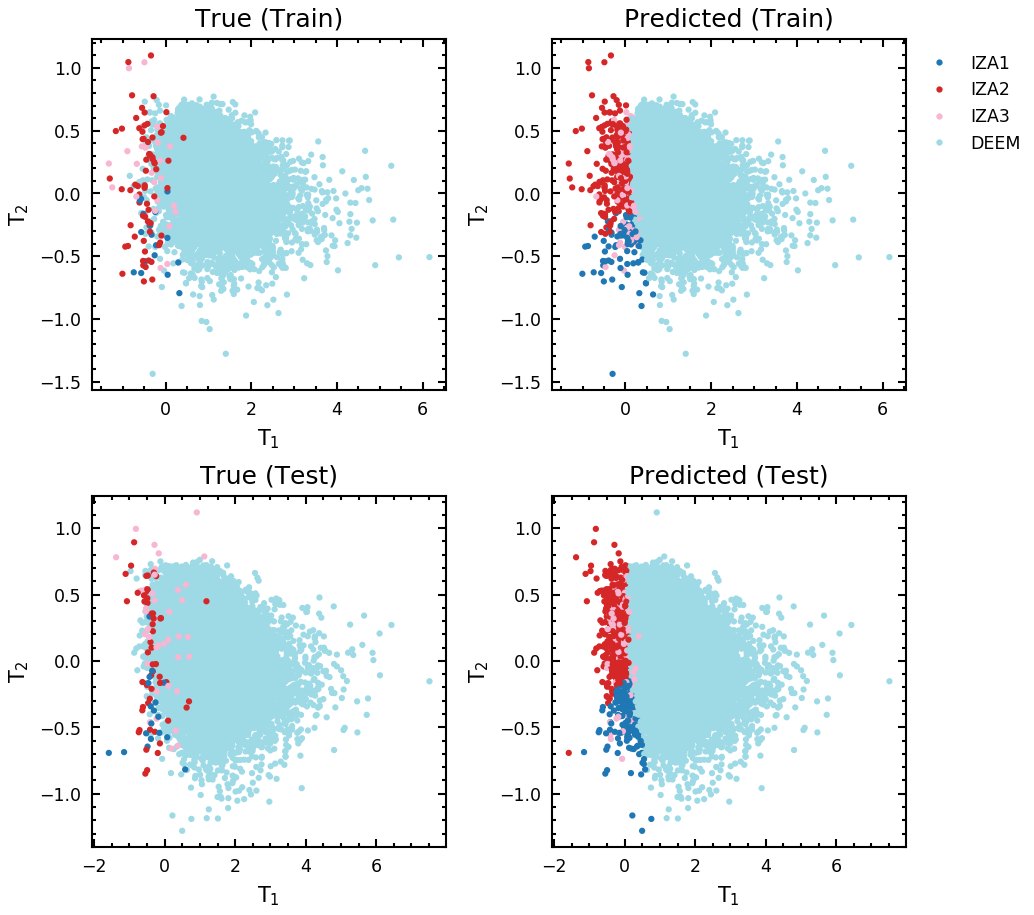

===== 6.0 | 4-Class | Radial | O =====


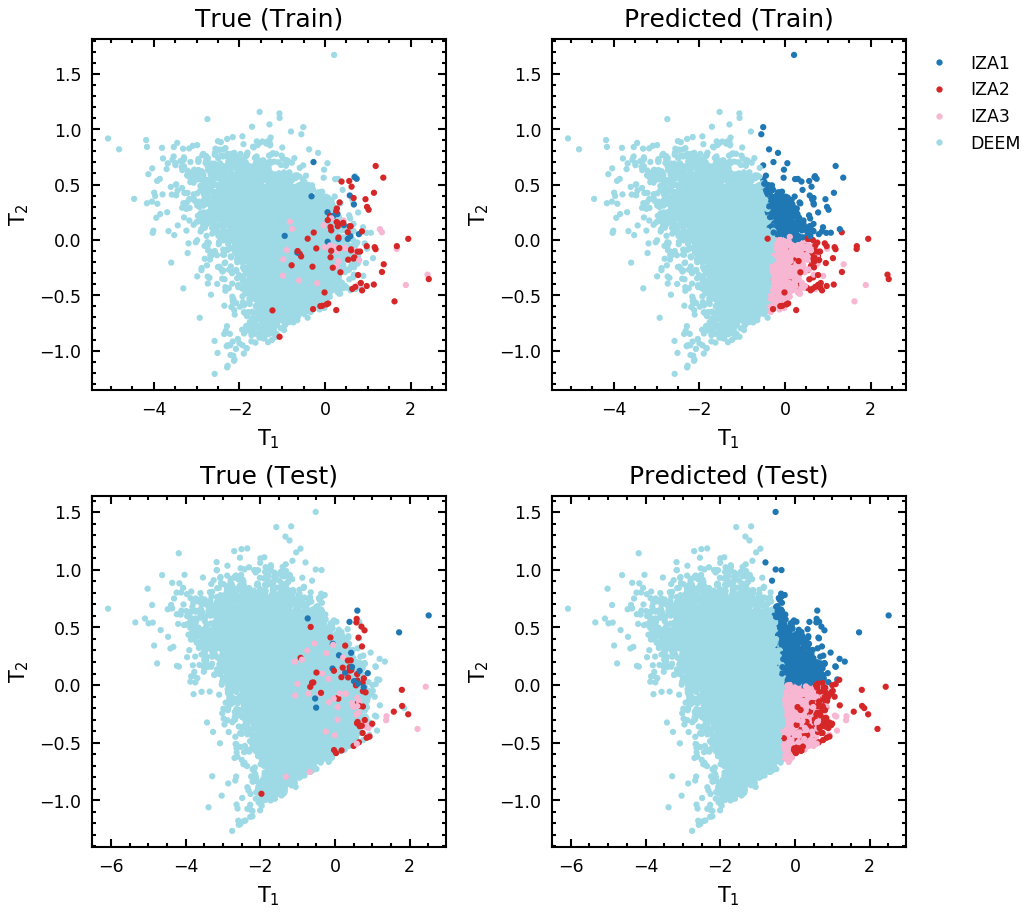

===== 6.0 | 4-Class | Radial | Si =====


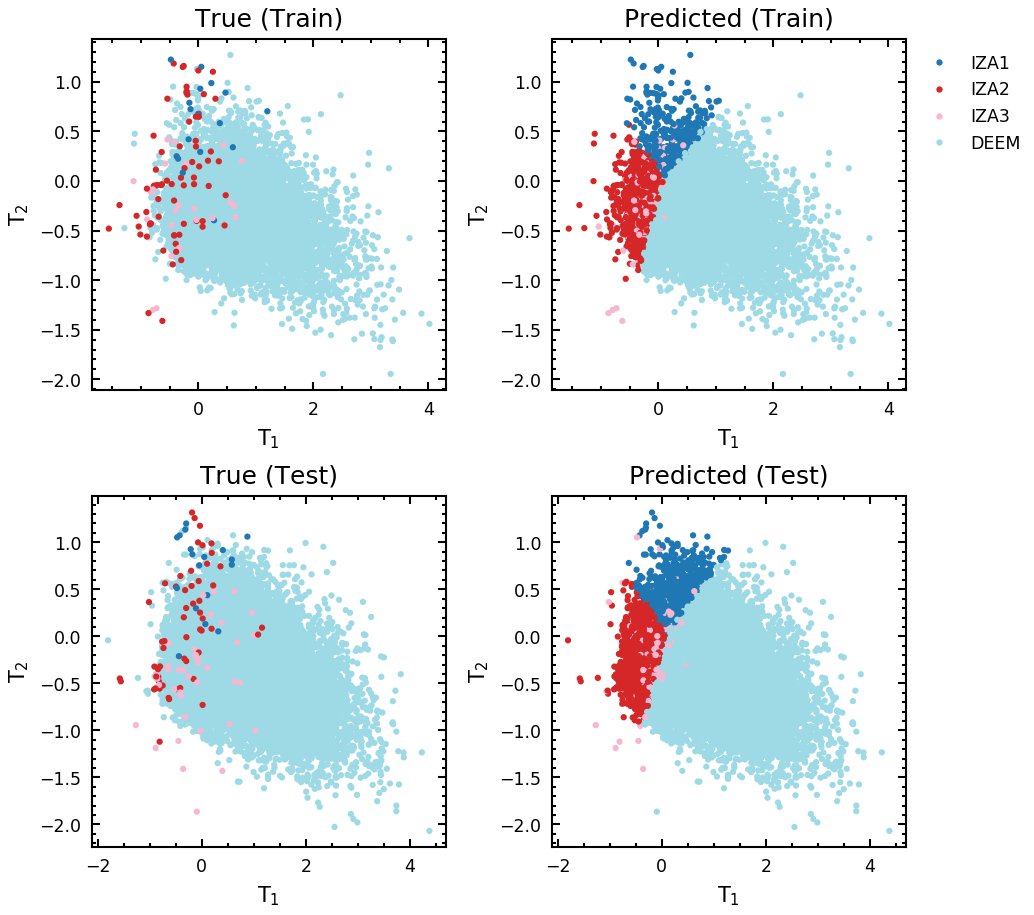

===== 6.0 | 4-Class | Radial | O+Si =====


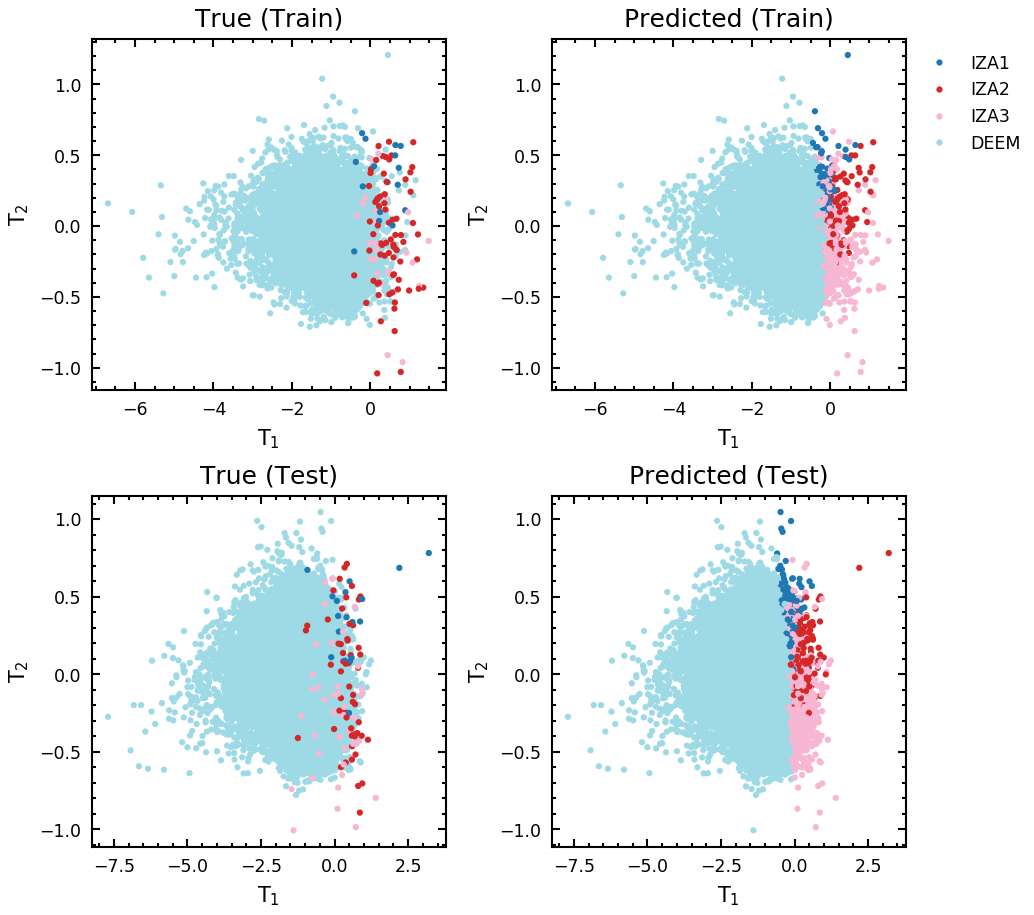

In [35]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in [4]: #(2, 4):
                
                # Prepare outputs
                data_dir = f'LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
                output_dir = f'../../Results/{cutoff}/LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
                
#                 os.makedirs(output_dir, exist_ok=True)
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')
    
                # Load projections
                deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_projections{mixing}.hdf5'
                T_deem = utils.load_hdf5(deem_file)[:, 0:2]

                iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_projections{mixing}.hdf5'
                T_iza = utils.load_hdf5(iza_file)[:, 0:2]

                # Load predicted cantons
                deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons{mixing}.dat'
                predicted_deem_cantons = np.loadtxt(deem_file, dtype=int)
                
                iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons{mixing}.dat'
                predicted_iza_cantons = np.loadtxt(iza_file, dtype=int)

                fig = plt.figure(figsize=(7.0, 7.0))
                axs_true_train = fig.add_subplot(2, 2, 1)
                axs_predicted_train = fig.add_subplot(2, 2, 2)
                axs_true_test = fig.add_subplot(2, 2, 3)
                axs_predicted_test = fig.add_subplot(2, 2, 4)
                scatter_opts = dict(cmap='tab20', vmin=1, vmax=4)
                df_idx = 0
                plot_stride = 10

                axs_true_train.scatter(
                    T_deem[deem_train_idxs, 0], 
                    T_deem[deem_train_idxs, 1], 
                    c=deem_cantons[deem_train_idxs], 
                    zorder=2, 
                    **scatter_opts
                )
                axs_true_train.scatter(
                    T_iza[iza_train_idxs, 0], 
                    T_iza[iza_train_idxs, 1], 
                    c=iza_cantons[iza_train_idxs], 
                    zorder=3, 
                    **scatter_opts
                )

                axs_predicted_train.scatter(
                    T_deem[deem_train_idxs, 0], 
                    T_deem[deem_train_idxs, 1], 
                    #c=df_deem_train[:, df_idx],
                    c=predicted_deem_cantons[deem_train_idxs], 
                    zorder=2, **scatter_opts
                )
                axs_predicted_train.scatter(
                    T_iza[iza_train_idxs, 0], 
                    T_iza[iza_train_idxs, 1], 
                    #c=df_iza_train[:, df_idx],
                    c=predicted_iza_cantons[iza_train_idxs], 
                    zorder=3, **scatter_opts
                )

                axs_true_test.scatter(
                    T_deem[deem_test_idxs[::plot_stride], 0], 
                    T_deem[deem_test_idxs[::plot_stride], 1],
                    c=deem_cantons[deem_test_idxs[::plot_stride]], 
                    zorder=2, 
                    **scatter_opts
                )
                axs_true_test.scatter(
                    T_iza[iza_test_idxs, 0], 
                    T_iza[iza_test_idxs, 1],
                    c=iza_cantons[iza_test_idxs], 
                    zorder=3, 
                    **scatter_opts
                )

                axs_predicted_test.scatter(
                    T_deem[deem_test_idxs[::plot_stride], 0], 
                    T_deem[deem_test_idxs[::plot_stride], 1],
                    #c=df_deem_test[:, df_idx])
                    c=predicted_deem_cantons[deem_test_idxs[::plot_stride]], 
                    zorder=2, 
                    **scatter_opts
                )
                axs_predicted_test.scatter(
                    T_iza[iza_test_idxs, 0], 
                    T_iza[iza_test_idxs, 1],
                    #c=df_iza_test[:, df_idx],
                    c=predicted_iza_cantons[iza_test_idxs], 
                    zorder=3, 
                    **scatter_opts
                )

                handles = [
                    Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
                    Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
                    Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
                    Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)
                ]

                labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
                axs_predicted_train.legend(
                    handles=handles, 
                    labels=labels, 
                    loc='upper left', 
                    bbox_to_anchor=(1.0, 1.0)
                )

                for ax in (axs_true_train, axs_predicted_train, axs_true_test, axs_predicted_test):
                    ax.set_xlabel(r'T$_1$')
                    ax.set_ylabel(r'T$_2$')

                axs_true_train.set_title('True (Train)')
                axs_predicted_train.set_title('Predicted (Train)')
                axs_true_test.set_title('True (Test)')
                axs_predicted_test.set_title('Predicted (Test)')

                fig.subplots_adjust(wspace=0.3, hspace=0.3)

                #fig.savefig(f'{output_dir}/svm-kpcovr.png', bbox_inches='tight')

                plt.show()

## Classification statistics

In [27]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in (2, 4):
                
                # Prepare outputs
                data_dir = f'{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')            
                
                predicted_iza_cantons = np.loadtxt(
                    f'{iza_dir}/{cutoff}/LPCovR/{data_dir}/pcovr_structure_cantons{mixing}.dat', dtype=int
                )
                predicted_deem_cantons = np.loadtxt(
                    f'{deem_dir}/{cutoff}/LPCovR/{data_dir}/pcovr_structure_cantons{mixing}.dat', dtype=int
                )

                predicted_train_cantons = np.concatenate((
                    predicted_iza_cantons[iza_train_idxs],
                    predicted_deem_cantons[deem_train_idxs]
                ))
                predicted_test_cantons = np.concatenate((
                    predicted_iza_cantons[iza_test_idxs],
                    predicted_deem_cantons[deem_test_idxs]
                ))

                iza_svc_dfs = np.loadtxt(f'{iza_dir}/{cutoff}/LSVC/{data_dir}/svc_structure_dfs.dat')
                deem_svc_dfs = np.loadtxt(f'{deem_dir}/{cutoff}/LSVC/{data_dir}/svc_structure_dfs.dat')

                iza_pcovr_dfs = np.loadtxt(f'{iza_dir}/{cutoff}/LPCovR/{data_dir}/pcovr_structure_dfs{mixing}.dat')
                deem_pcovr_dfs = np.loadtxt(f'{deem_dir}/{cutoff}/LPCovR/{data_dir}/pcovr_structure_dfs{mixing}.dat')

                svc_train_dfs = np.concatenate((
                    iza_svc_dfs[iza_train_idxs],
                    deem_svc_dfs[deem_train_idxs]
                ))
                svc_test_dfs = np.concatenate((
                    iza_svc_dfs[iza_test_idxs],
                    deem_svc_dfs[deem_test_idxs]
                ))

                pcovr_train_dfs = np.concatenate((
                    iza_pcovr_dfs[iza_train_idxs],
                    deem_pcovr_dfs[deem_train_idxs]
                ))
                pcovr_test_dfs = np.concatenate((
                    iza_pcovr_dfs[iza_test_idxs],
                    deem_pcovr_dfs[deem_test_idxs]
                ))

                matrix_train = confusion_matrix(train_cantons[n_cantons], predicted_train_cantons)
                matrix_test = confusion_matrix(test_cantons[n_cantons], predicted_test_cantons)

                print('----- Train -----')
                print(
                    classification_report(
                        train_cantons[n_cantons], predicted_train_cantons, zero_division=0
                    )
                )
                print('Train accuracy:', balanced_accuracy_score(
                    train_cantons[n_cantons], predicted_train_cantons
                ))
                print()
                print(matrix_train)
                print()
                print('Train DF RMSE:', mean_squared_error(svc_train_dfs, pcovr_train_dfs, squared=False))
                print()

                print('----- Test -----')
                print(
                    classification_report(
                        test_cantons[n_cantons], predicted_test_cantons, zero_division=0
                    )
                )
                print('Test accuracy:', balanced_accuracy_score(
                    test_cantons[n_cantons], predicted_test_cantons
                ))
                print()
                print(matrix_test)
                print()
                print('Test DF RMSE:', mean_squared_error(svc_test_dfs, pcovr_test_dfs, squared=False))
                print()

===== 3.5 | 2-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.11      0.98      0.19       114
           2       1.00      0.91      0.95      9999

    accuracy                           0.91     10113
   macro avg       0.55      0.94      0.57     10113
weighted avg       0.99      0.91      0.94     10113

Train accuracy: 0.9444233897073917

[[ 112    2]
 [ 936 9063]]

Train DF RMSE: 0.1374479317363753

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.88      0.01       115
           2       1.00      0.91      0.95    321082

    accuracy                           0.91    321197
   macro avg       0.50      0.89      0.48    321197
weighted avg       1.00      0.91      0.95    321197

Test accuracy: 0.8918901659416273

[[   101     14]
 [ 30336 290746]]

Test DF RMSE: 0.14246563656667727

===== 3.5 | 4-Class | Power | OO =====
----- Train -----
          

              precision    recall  f1-score   support

           1       0.00      0.78      0.00        18
           2       0.00      0.58      0.00        55
           3       0.00      0.05      0.00        42
           4       1.00      0.89      0.94    321082

    accuracy                           0.89    321197
   macro avg       0.25      0.57      0.24    321197
weighted avg       1.00      0.89      0.94    321197

Test accuracy: 0.5747397930642398

[[    14      4      0      0]
 [    20     32      1      2]
 [     5     26      2      9]
 [ 18547  14695   1517 286323]]

Test DF RMSE: 0.5323151194623938

===== 3.5 | 2-Class | Power | OO+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.12      0.99      0.21       114
           2       1.00      0.92      0.96      9999

    accuracy                           0.92     10113
   macro avg       0.56      0.95      0.58     10113
weighted avg       0.99      0.92   

----- Train -----
              precision    recall  f1-score   support

           1       0.01      0.18      0.03        17
           2       0.06      0.44      0.10        71
           3       0.01      0.27      0.01        26
           4       1.00      0.82      0.90      9999

    accuracy                           0.81     10113
   macro avg       0.27      0.42      0.26     10113
weighted avg       0.99      0.81      0.89     10113

Train accuracy: 0.4248256934864349

[[   3    3    9    2]
 [   8   31   31    1]
 [   4   13    7    2]
 [ 205  509 1116 8169]]

Train DF RMSE: 1.27150064513874

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.11      0.00        18
           2       0.00      0.45      0.00        55
           3       0.00      0.29      0.00        42
           4       1.00      0.82      0.90    321082

    accuracy                           0.82    321197
   macro avg       0.25      0.42      0.

              precision    recall  f1-score   support

           1       0.01      0.89      0.01       115
           2       1.00      0.95      0.97    321082

    accuracy                           0.95    321197
   macro avg       0.50      0.92      0.49    321197
weighted avg       1.00      0.95      0.97    321197

Test accuracy: 0.9179193693714433

[[   102     13]
 [ 16413 304669]]

Test DF RMSE: 0.0797139727114256

===== 6.0 | 4-Class | Power | OSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.11      0.59      0.18        17
           2       0.17      0.55      0.26        71
           3       0.04      0.35      0.07        26
           4       1.00      0.96      0.98      9999

    accuracy                           0.95     10113
   macro avg       0.33      0.61      0.37     10113
weighted avg       0.99      0.95      0.97     10113

Train accuracy: 0.6097201086178339

[[  10    6    1    0]
 [  14   39   17

----- Train -----
              precision    recall  f1-score   support

           1       0.21      0.97      0.35       114
           2       1.00      0.96      0.98      9999

    accuracy                           0.96     10113
   macro avg       0.61      0.97      0.66     10113
weighted avg       0.99      0.96      0.97     10113

Train accuracy: 0.9661900400566372

[[ 111    3]
 [ 413 9586]]

Train DF RMSE: 0.08592890163068578

----- Test -----
              precision    recall  f1-score   support

           1       0.01      0.88      0.01       115
           2       1.00      0.95      0.98    321082

    accuracy                           0.95    321197
   macro avg       0.50      0.91      0.49    321197
weighted avg       1.00      0.95      0.97    321197

Test accuracy: 0.9147690566922766

[[   101     14]
 [ 15644 305438]]

Test DF RMSE: 0.08525848426899085

===== 6.0 | 4-Class | Power | OSi+SiSi =====
----- Train -----
              precision    recall  f1-scor

              precision    recall  f1-score   support

           1       0.00      0.83      0.00        18
           2       0.00      0.53      0.00        55
           3       0.00      0.29      0.00        42
           4       1.00      0.78      0.88    321082

    accuracy                           0.78    321197
   macro avg       0.25      0.61      0.22    321197
weighted avg       1.00      0.78      0.88    321197

Test accuracy: 0.6062943651755855

[[    15      1      1      1]
 [    20     29      2      4]
 [     2     16     12     12]
 [ 11229  40908  18868 250077]]

Test DF RMSE: 0.3210290198117903

===== 6.0 | 2-Class | Radial | O+Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.19      0.99      0.32       114
           2       1.00      0.95      0.98      9999

    accuracy                           0.95     10113
   macro avg       0.60      0.97      0.65     10113
weighted avg       0.99      0.95     